# House Prices Regression Exercise – Solution

Dataset: [House Prices - Advanced Regression Techniques (Kaggle)](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques)

This notebook walks through data cleaning, outlier detection, EDA, transformations, feature engineering, feature selection,
multiple regression models, hyperparameter tuning (Optuna & Hyperopt), error analysis, and model interpretation using SHAP and LIME.


In [41]:
# Imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import mutual_info_regression

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

import optuna
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

import shap
from lime.lime_tabular import LimeTabularExplainer

sns.set(style="whitegrid")


In [42]:
# 1. Load data
# Make sure train.csv from the Kaggle competition is in the same folder as this notebook
data = pd.read_csv('/Users/omarcharif/Downloads/house-prices-advanced-regression-techniques/train.csv')
print(data.shape)
data.head()


(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [43]:
# Basic info
data.info()

data.describe().T.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0


In [44]:
data.shape

(1460, 81)

In [45]:
missing_df = pd.DataFrame()
# 2. Data cleaning – handle missing values
missing_df["count"] = data.isna().sum().sort_values(ascending=False)


# missing percentage
missing_df["percentage"] = missing_df["count"]/data.shape[0]


missing_df[missing_df["count"] > 0].head(20)

,count,percentage
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
MasVnrType,872,0.597260
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479


### Separate target and features


In [46]:
target = 'SalePrice'
y = data[target]
X = data.drop(columns=[target])

# Drop Id (we treat it as an identifier, not a feature)
if 'Id' in X.columns:
    X = X.drop(columns=['Id'])

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()
numeric_features[:10], categorical_features[:10]


(['MSSubClass',
  'LotFrontage',
  'LotArea',
  'OverallQual',
  'OverallCond',
  'YearBuilt',
  'YearRemodAdd',
  'MasVnrArea',
  'BsmtFinSF1',
  'BsmtFinSF2'],
 ['MSZoning',
  'Street',
  'Alley',
  'LotShape',
  'LandContour',
  'Utilities',
  'LotConfig',
  'LandSlope',
  'Neighborhood',
  'Condition1'])

In [47]:
# Preprocess: impute + scale numeric, impute + one-hot encode categorical
from sklearn.preprocessing import OneHotEncoder

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


## 3. Outlier detection (on raw numeric features)


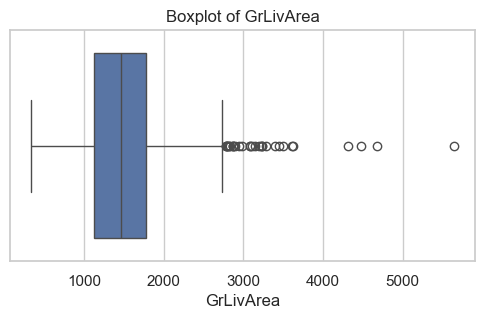

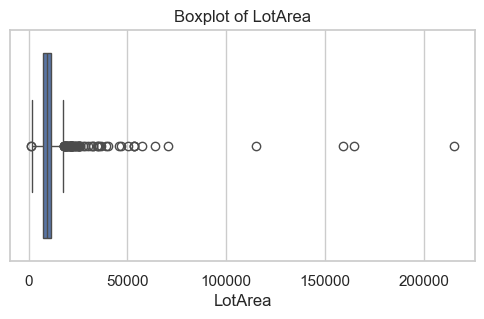

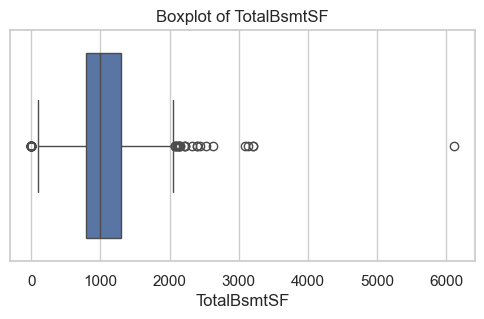

Shape before: (1460, 81) after: (1456, 81)


In [ ]:
# Example: detect outliers using IQR for a few important features
key_numeric = ['GrLivArea', 'LotArea', 'TotalBsmtSF']
for col in key_numeric:
    if col in data.columns:
        plt.figure(figsize=(6, 3))
        sns.boxplot(x=data[col])
        plt.title(f'Boxplot of {col}')
        plt.show()

# Optionally remove extreme outliers for GrLivArea as commonly done in this dataset
clean_data = data.copy()
if 'GrLivArea' in clean_data.columns:
    q1, q3 = clean_data['GrLivArea'].quantile([0.25, 0.75])
    iqr = q3 - q1
    upper = q3 + 3 * iqr
    clean_data = clean_data[clean_data['GrLivArea'] <= upper]
    print('Shape before:', data.shape, 'after:', clean_data.shape)

data = clean_data==≠
y = data[target]
X = data.drop(columns=[target, 'Id']) if 'Id' in data.columns else data.drop(columns=[target])


## 4. Exploratory Data Analysis (EDA)


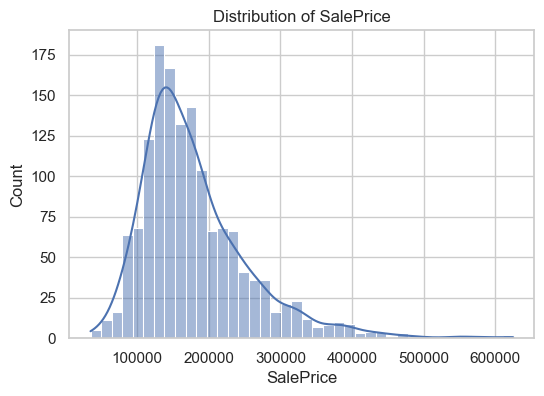

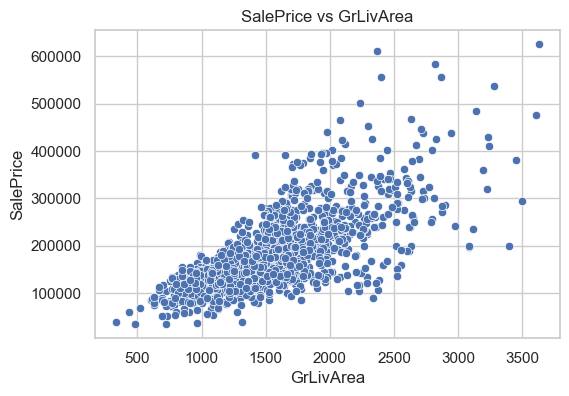

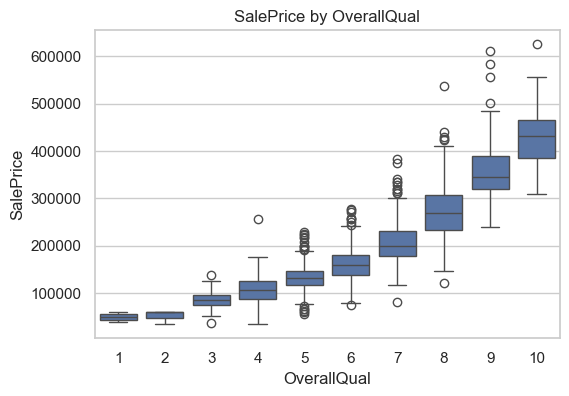

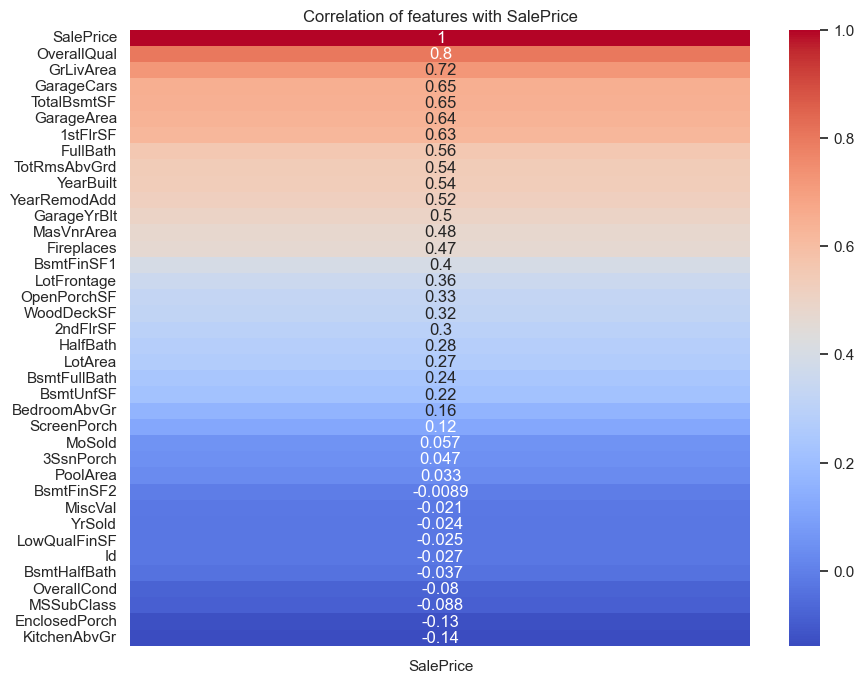

In [49]:
# Distribution of SalePrice
plt.figure(figsize=(6,4))
sns.histplot(y, kde=True)
plt.title('Distribution of SalePrice')
plt.show()

# Relationship with a numeric feature
if 'GrLivArea' in data.columns:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=data['GrLivArea'], y=y)
    plt.title('SalePrice vs GrLivArea')
    plt.show()

# Relationship with a categorical feature
if 'OverallQual' in data.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=data['OverallQual'], y=y)
    plt.title('SalePrice by OverallQual')
    plt.show()

# Correlation heatmap for numeric features
corr = data.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr['SalePrice'].sort_values(ascending=False).to_frame(), annot=True, cmap='coolwarm')
plt.title('Correlation of features with SalePrice')
plt.show()


## 5. Target transformation and train-test split


In [50]:
# Log-transform the target to reduce skewness
y_log = np.log1p(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)
X_train.shape, X_test.shape


((1164, 79), (292, 79))

## 6. Feature engineering (new and interaction features)


In [62]:
def add_engineered_features(df):
    df = df.copy()
    # Total square footage: basement + 1st + 2nd floor
    if all(col in df.columns for col in ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF']):
        df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

    # House age at sale
    if all(col in df.columns for col in ['YrSold', 'YearBuilt']):
        df['HouseAge'] = df['YrSold'] - df['YearBuilt']

    # Total bathrooms
    for col in ['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath']:
        if col not in df.columns:
            df[col] = 0
    df['TotalBaths'] = df['FullBath'] + 0.5*df['HalfBath'] + df['BsmtFullBath'] + 0.5*df['BsmtHalfBath']

    # Interaction: quality * size
    if all(col in df.columns for col in ['OverallQual', 'GrLivArea']):
        df['Qual_x_GrLivArea'] = df['OverallQual'] * df['GrLivArea']

    # Interaction: age * total square footage (if available)
    if 'HouseAge' in df.columns and 'TotalSF' in df.columns:
        df['Age_x_TotalSF'] = df['HouseAge'] * df['TotalSF']

    return df

X_train_fe = add_engineered_features(X_train)
X_test_fe = add_engineered_features(X_test)

numeric_features = X_train_fe.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train_fe.select_dtypes(exclude=[np.number]).columns.tolist()
len(numeric_features), len(categorical_features)


(41, 43)

## 7. Updated preprocessor and feature selection


In [63]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Quickly fit a RandomForest to estimate feature importance after preprocessing
rf_for_fs = Pipeline(steps=[
    ('prep', preprocessor),
    ('model', RandomForestRegressor(n_estimators=200, random_state=42))
])

rf_for_fs.fit(X_train_fe, y_train)

# Get feature importances from the trained random forest
ohe = rf_for_fs.named_steps['prep'].named_transformers_['cat'].named_steps['onehot'] if categorical_features else None

num_feature_names = numeric_features
cat_feature_names = (ohe.get_feature_names_out(categorical_features).tolist() if ohe is not None else [])
all_feature_names = num_feature_names + cat_feature_names

importances = rf_for_fs.named_steps['model'].feature_importances_
feat_imp = pd.Series(importances, index=all_feature_names).sort_values(ascending=False)
feat_imp.head(20)


Qual_x_GrLivArea    0.645197
TotalSF             0.088955
OverallQual         0.022748
BsmtFinSF1          0.022718
TotalBsmtSF         0.019282
GarageArea          0.012596
GarageCars          0.011483
YearBuilt           0.011190
HouseAge            0.010233
GarageFinish_Unf    0.009684
TotalBaths          0.009520
YearRemodAdd        0.009084
LotArea             0.007657
OverallCond         0.007258
1stFlrSF            0.006552
MSZoning_RM         0.005327
BsmtUnfSF           0.005246
Age_x_TotalSF       0.004009
ExterQual_TA        0.003968
BsmtQual_Ex         0.003642
dtype: float64

In [64]:
#  data processing

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

print("Preparing ORIGINAL dataset...")

# -------------------------------------
# 1) Prepare X and y (original dataset)
# -------------------------------------
y_num = data["SalePrice"].values
X_orig = data.drop(columns=["SalePrice", "Id"], errors="ignore")

# Identify numeric and categorical columns
num_cols = X_orig.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_orig.select_dtypes(exclude=[np.number]).columns.tolist()

# -------------------------------------
# 2) Impute missing values (required!)
# -------------------------------------

# Numeric → median
num_imputer = SimpleImputer(strategy="median")
X_num_imputed = pd.DataFrame(
    num_imputer.fit_transform(X_orig[num_cols]),
    columns=num_cols
)

# Categorical → "Missing"
cat_imputer = SimpleImputer(strategy="most_frequent")
X_cat_imputed = pd.DataFrame(
    cat_imputer.fit_transform(X_orig[cat_cols]),
    columns=cat_cols
)

# -------------------------------------
# 3) Combine & One-Hot Encode
# -------------------------------------
X_clean = pd.concat([X_num_imputed, X_cat_imputed], axis=1)

# One-hot encode categoricals
X_encoded = pd.get_dummies(X_clean, drop_first=True)

X_num = X_encoded.copy()
feature_list = X_num.columns.tolist()

print(f"Final feature count after one-hot encoding: {X_num.shape[1]}")

# Store results
fs_results = {}


Preparing ORIGINAL dataset...
Final feature count after one-hot encoding: 243


In [65]:
# SelectKBest
print("\nRunning SelectKBest...")
k = 20
selector_kbest = SelectKBest(score_func=f_regression, k=k)
selector_kbest.fit(X_num, y_num)

selected_kbest = list(X_num.columns[selector_kbest.get_support()])
fs_results["SelectKBest"] = selected_kbest
print(f"SelectKBest selected {len(selected_kbest)} features.")
print(selected_kbest)



Running SelectKBest...
SelectKBest selected 20 features.
['OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'ExterQual_Gd', 'ExterQual_TA', 'Foundation_PConc', 'BsmtQual_TA', 'BsmtFinType1_GLQ', 'KitchenQual_TA', 'GarageFinish_Unf']


In [66]:
for k in range(20, data.shape[1], 5):
    selector_kbest = SelectKBest(score_func=f_regression, k=k)
    selector_kbest.fit(X_num, y_num)

    selected_kbest = list(X_num.columns[selector_kbest.get_support()])
    fs_results["SelectKBest"] = selected_kbest
    print(f"SelectKBest selected {len(selected_kbest)} features.")
    print(selected_kbest)
    # train a simple model

SelectKBest selected 20 features.
['OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'ExterQual_Gd', 'ExterQual_TA', 'Foundation_PConc', 'BsmtQual_TA', 'BsmtFinType1_GLQ', 'KitchenQual_TA', 'GarageFinish_Unf']
SelectKBest selected 25 features.
['OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'Neighborhood_NridgHt', 'ExterQual_Gd', 'ExterQual_TA', 'Foundation_PConc', 'BsmtQual_TA', 'BsmtFinType1_GLQ', 'KitchenQual_TA', 'GarageType_Detchd', 'GarageFinish_Unf', 'SaleType_New', 'SaleCondition_Partial']
SelectKBest selected 30 features.
['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrB

In [60]:
# SelectFromModel (LASSO)
print("\nRunning SelectFromModel (LASSO)...")

model_sfm = Lasso(alpha=0.0005, max_iter=20000, random_state=42)
sfm = SelectFromModel(model_sfm)
sfm.fit(X_num, y_num)

selected_sfm = list(X_num.columns[sfm.get_support()])
fs_results["SelectFromModel (Lasso)"] = selected_sfm
print(f"SelectFromModel (Lasso) selected {len(selected_sfm)} features.")
print(selected_sfm)



Running SelectFromModel (LASSO)...
SelectFromModel (Lasso) selected 243 features.
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Street_Pave', 'Alley_Pave', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'Utilities_NoSeWa', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr'

In [61]:
#  RFE (with RandomForest)
print("\nRunning RFE (RandomForest)...")

estimator_rfe = RandomForestRegressor(n_estimators=150, random_state=42)
rfe = RFE(estimator=estimator_rfe, n_features_to_select=20)
rfe.fit(X_num, y_num)

selected_rfe = list(X_num.columns[rfe.get_support()])
fs_results["RFE"] = selected_rfe
print(f"RFE selected {len(selected_rfe)} features.")
print(selected_rfe)


Running RFE (RandomForest)...
RFE selected 20 features.
['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF']


In [67]:
#  sequantial method
print("\nRunning Sequential Forward Selection...")

lr = LinearRegression()

sfs_forward = SequentialFeatureSelector(
    lr, direction="forward", n_features_to_select=15, cv=5, n_jobs=-1
)
sfs_forward.fit(X_num, y_num)

selected_forward = list(X_num.columns[sfs_forward.get_support()])
fs_results["SFS Forward"] = selected_forward
print(f"SFS Forward selected {len(selected_forward)} features.")
print(selected_forward)

print("\nRunning Sequential Backward Selection...")

sfs_backward = SequentialFeatureSelector(
    lr, direction="backward", n_features_to_select=15, cv=5, n_jobs=-1
)
sfs_backward.fit(X_num, y_num)

selected_backward = list(X_num.columns[sfs_backward.get_support()])
fs_results["SFS Backward"] = selected_backward
print(f"SFS Backward selected {len(selected_backward)} features.")
print(selected_backward)


Running Sequential Forward Selection...
SFS Forward selected 15 features.
['MSSubClass', 'LotArea', 'OverallQual', 'YearRemodAdd', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea', 'BedroomAbvGr', 'GarageCars', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_StoneBr', 'BsmtExposure_Gd', 'Functional_Typ', 'SaleType_New']

Running Sequential Backward Selection...


KeyboardInterrupt: 

In [68]:
summary = pd.DataFrame.from_dict(fs_results, orient="index").transpose()

print("\n================ FEATURE SELECTION SUMMARY ================")
summary.fillna("").head(50)


================ FEATURE SELECTION SUMMARY ================


,SelectKBest,SFS Forward
0,LotFrontage,MSSubClass
1,LotArea,LotArea
2,OverallQual,OverallQual
3,YearBuilt,YearRemodAdd
4,YearRemodAdd,BsmtFinSF1
5,MasVnrArea,TotalBsmtSF
6,BsmtFinSF1,GrLivArea
7,BsmtUnfSF,BedroomAbvGr
8,TotalBsmtSF,GarageCars
9,1stFlrSF,Neighborhood_NoRidge


## 8. Baseline models


In [70]:
models = {
    'LinearRegression': LinearRegression(),
    'KNN': KNeighborsRegressor(),
    'SVR': SVR(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBRegressor': XGBRegressor(random_state=42, n_estimators=500, learning_rate=0.05)
}

results = {}
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    pipe = Pipeline(steps=[('prep', preprocessor), ('model', model)])
    rmse_scores = np.sqrt(-cross_val_score(pipe, X_train_fe, y_train, scoring='neg_mean_squared_error', cv=kf))
    results[name] = rmse_scores
    print(name, 'RMSE (mean \u00b1 std):', rmse_scores.mean(), '+/-', rmse_scores.std())


LinearRegression RMSE (mean ± std): 0.12830511010565115 +/- 0.012799642123299924
KNN RMSE (mean ± std): 0.15927209282157068 +/- 0.012248852103416627
SVR RMSE (mean ± std): 0.13738590771150205 +/- 0.018824530514724155
RandomForest RMSE (mean ± std): 0.13349854866412852 +/- 0.016111943235513793
XGBRegressor RMSE (mean ± std): 0.12691533145380865 +/- 0.013698278313062516


## 9. Hyperparameter tuning with Optuna (XGBoost example)


In [83]:
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 800),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'random_state': 42,
        'objective': 'reg:squarederror'
    }

    model = XGBRegressor(**params)
    pipe = Pipeline(steps=[('prep', preprocessor), ('model', model)])

    rmse = np.sqrt(-cross_val_score(
        pipe, X_train_fe, y_train,
        scoring='neg_mean_squared_error', cv=3
    ).mean())
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective_xgb, n_trials=30, show_progress_bar=False)
print('Best RMSE:', study.best_value)
print('Best params:', study.best_params)


[I 2025-12-03 19:30:42,020] A new study created in memory with name: no-name-e9794b27-b1b2-4232-b4f5-2d4b823887a1
[I 2025-12-03 19:30:44,357] Trial 0 finished with value: 0.13245954679255853 and parameters: {'n_estimators': 742, 'learning_rate': 0.1855514202587358, 'max_depth': 7, 'subsample': 0.6363008102255674, 'colsample_bytree': 0.7367219777339321, 'min_child_weight': 2}. Best is trial 0 with value: 0.13245954679255853.
[I 2025-12-03 19:30:47,696] Trial 1 finished with value: 0.12480856605551294 and parameters: {'n_estimators': 743, 'learning_rate': 0.09617345468673466, 'max_depth': 5, 'subsample': 0.5225937483730755, 'colsample_bytree': 0.6393922607241831, 'min_child_weight': 8}. Best is trial 1 with value: 0.12480856605551294.
[I 2025-12-03 19:30:50,358] Trial 2 finished with value: 0.12194786746002334 and parameters: {'n_estimators': 342, 'learning_rate': 0.04218815758756378, 'max_depth': 9, 'subsample': 0.6426915170978402, 'colsample_bytree': 0.6537470410067445, 'min_child_weig

Best RMSE: 0.11696266270591468
Best params: {'n_estimators': 578, 'learning_rate': 0.022344709139476934, 'max_depth': 3, 'subsample': 0.785774637226643, 'colsample_bytree': 0.785339160307523, 'min_child_weight': 2}


## 10. Hyperparameter tuning with Hyperopt (RandomForest example)


In [84]:
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 800, 50),
    'max_depth': hp.quniform('max_depth', 3, 20, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1)
}

def objective_rf(params):
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['min_samples_split'] = int(params['min_samples_split'])
    params['min_samples_leaf'] = int(params['min_samples_leaf'])
    params['random_state'] = 42

    model = RandomForestRegressor(**params)
    pipe = Pipeline(steps=[('prep', preprocessor), ('model', model)])
    rmse = np.sqrt(-cross_val_score(pipe, X_train_fe, y_train, scoring='neg_mean_squared_error', cv=3).mean())
    return {'loss': rmse, 'status': STATUS_OK}

trials = Trials()
best = fmin(fn=objective_rf, space=space, algo=tpe.suggest, max_evals=30, trials=trials)
best


100%|██████████| 30/30 [03:31<00:00,  7.06s/trial, best loss: 0.13569024675683722]


{'max_depth': np.float64(18.0),
 'min_samples_leaf': np.float64(1.0),
 'min_samples_split': np.float64(3.0),
 'n_estimators': np.float64(350.0)}

## 11. Fit best model and evaluate on test set


Test RMSE: 19662.07120134637
Test MAE: 13482.588934075344
Test R2: 0.9263402763404274


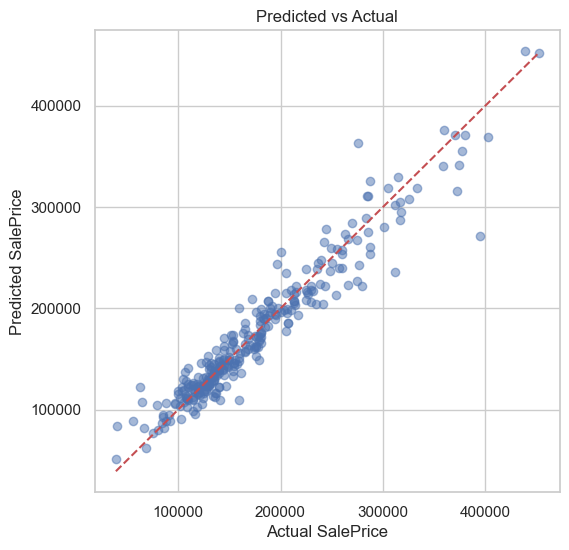

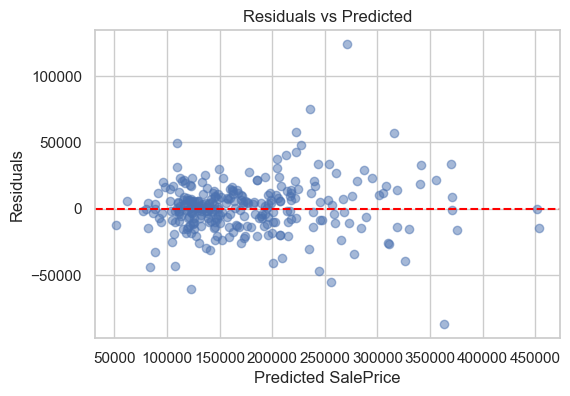

In [87]:
# Example: use tuned XGB params (from Optuna) as best model
best_xgb_params = study.best_params
best_xgb_params.update({'random_state': 42, 'objective': 'reg:squarederror'})
best_xgb = XGBRegressor(**best_xgb_params)

best_pipe = Pipeline(steps=[('prep', preprocessor), ('model', best_xgb)])
best_pipe.fit(X_train_fe, y_train)

y_pred_log = best_pipe.predict(X_test_fe)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print('Test RMSE:', rmse)
print('Test MAE:', mae)
print('Test R2:', r2)

# Error analysis
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Predicted vs Actual')
plt.show()

residuals = y_true - y_pred
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted SalePrice')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.show()


## 12. SHAP value interpretation


Building SHAP TreeExplainer...
Computing SHAP values...
Plotting SHAP summary...


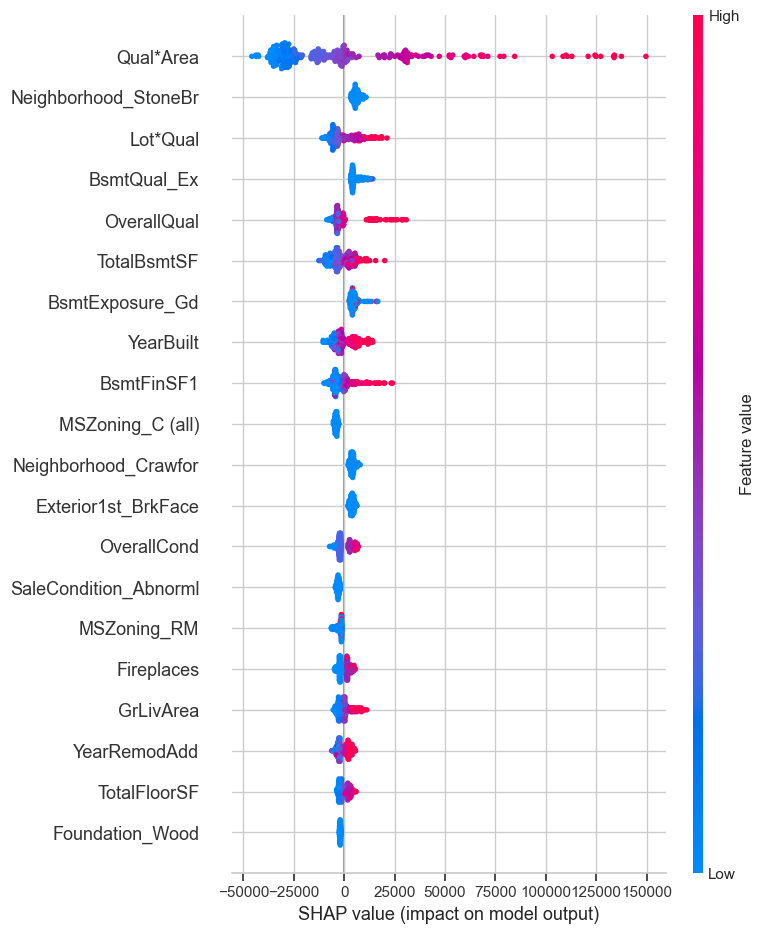

Plotting SHAP waterfall for sample #10...


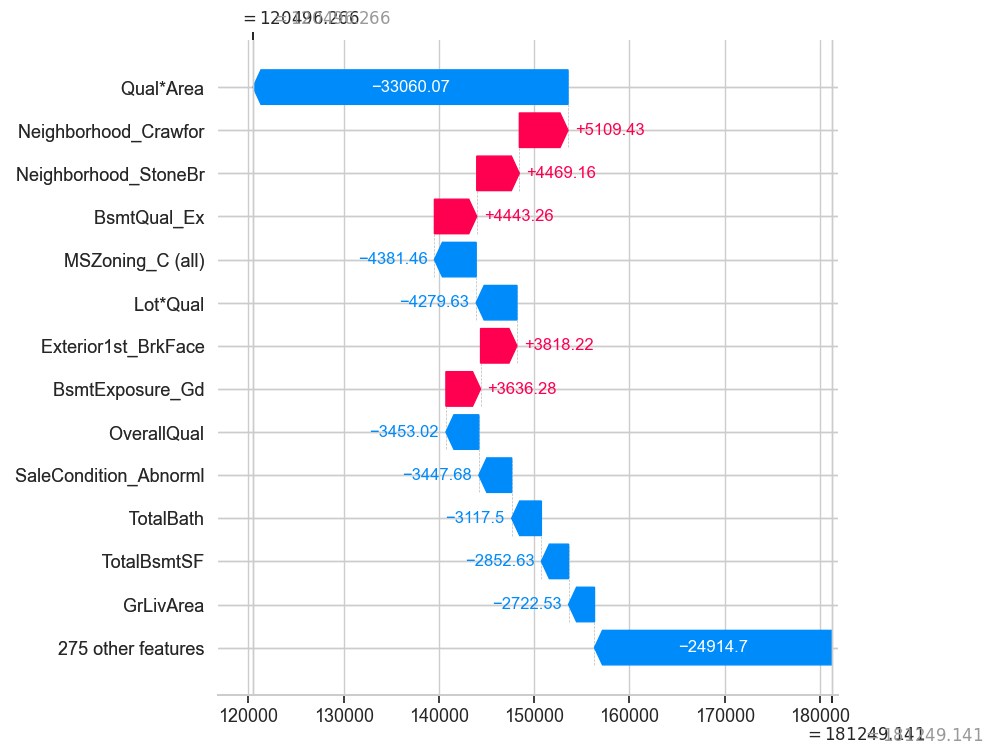

In [ ]:
import numpy as np
import pandas as pd
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor

# ------------------------------------------------------------
# 1️⃣ Load original dataset (raw)
# ------------------------------------------------------------
df = data.copy()     # if already loaded; otherwise pd.read_csv("train.csv")

y = df["SalePrice"]
X = df.drop(columns=["SalePrice", "Id"], errors="ignore")


# ------------------------------------------------------------
# 2️⃣ Feature Engineering (from scratch)
# ------------------------------------------------------------

# Example engineered features:
X_fe = X.copy()

# Total floor SF
X_fe["TotalFloorSF"] = X_fe["1stFlrSF"] + X_fe["2ndFlrSF"]

# House age
X_fe["HouseAge"] = X_fe["YrSold"] - X_fe["YearBuilt"]

# Total baths
X_fe["TotalBath"] = (
    X_fe["FullBath"] + 0.5 * X_fe["HalfBath"] +
    X_fe["BsmtFullBath"] + 0.5 * X_fe["BsmtHalfBath"]
)

# Interaction: Quality × Living Area
X_fe["Qual*Area"] = X_fe["OverallQual"] * X_fe["GrLivArea"]

# Interaction: Lot Area × OverallQual
X_fe["Lot*Qual"] = X_fe["LotArea"] * X_fe["OverallQual"]

# Proceed with split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_fe, y, test_size=0.2, random_state=42
)

# ------------------------------------------------------------
# 3️⃣ Preprocessing Pipeline (Impute → OHE → Scale)
# ------------------------------------------------------------
num_cols = X_train_raw.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train_raw.select_dtypes(exclude=[np.number]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),
        
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols)
    ]
)

# ------------------------------------------------------------
# 4️⃣ Build final model pipeline
# ------------------------------------------------------------
model = Pipeline([
    ("preprocess", preprocessor),
    ("regressor", XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8
    ))
])

# Train
model.fit(X_train_raw, y_train)

# ------------------------------------------------------------
# 5️⃣ Prepare processed data for SHAP
# ------------------------------------------------------------
# We must extract encoded feature names
ohe = model.named_steps["preprocess"].named_transformers_["cat"].named_steps["ohe"]
ohe_features = ohe.get_feature_names_out(cat_cols)

num_features = num_cols
all_features = list(num_features) + list(ohe_features)

# Get dense processed matrices
X_train_processed = model.named_steps["preprocess"].transform(X_train_raw)
X_test_processed  = model.named_steps["preprocess"].transform(X_test_raw)

X_train_df = pd.DataFrame(X_train_processed.toarray(), columns=all_features)
X_test_df  = pd.DataFrame(X_test_processed.toarray(),  columns=all_features)


# ------------------------------------------------------------
# 6️⃣ SHAP (TreeExplainer) — BEST for XGBoost
# ------------------------------------------------------------
print("Building SHAP TreeExplainer...")
explainer_shap = shap.TreeExplainer(model.named_steps["regressor"])

print("Computing SHAP values...")
shap_values = explainer_shap.shap_values(X_test_df)

# Summary Plot
print("Plotting SHAP summary...")
shap.summary_plot(shap_values, X_test_df, feature_names=all_features, max_display=20)

# Waterfall Plot for sample
sample_ind = 10
print(f"Plotting SHAP waterfall for sample #{sample_ind}...")
# SHAP waterfall plot (correct format)
shap.plots._waterfall.waterfall_legacy(
    explainer_shap.expected_value,
    shap_values[sample_ind],
    X_test_df.iloc[sample_ind],
    feature_names=all_features,
    max_display=14
)


Categorical encoding for LIME complete.

🔍 LIME Top Features Table:


,Feature,Contribution
0,Qual*Area,23613.287273
1,Street=Pave,7353.933532
2,PoolQC=nan,-6047.061569
3,Functional=Typ,5507.995609
4,SaleCondition=Normal,3833.138289
5,GarageFinish=Unf,-3707.524749
6,MSZoning=RL,3635.851767
7,GrLivArea,2533.331808
8,ExterQual=TA,-2494.507222
9,TotalFloorSF,2472.740476


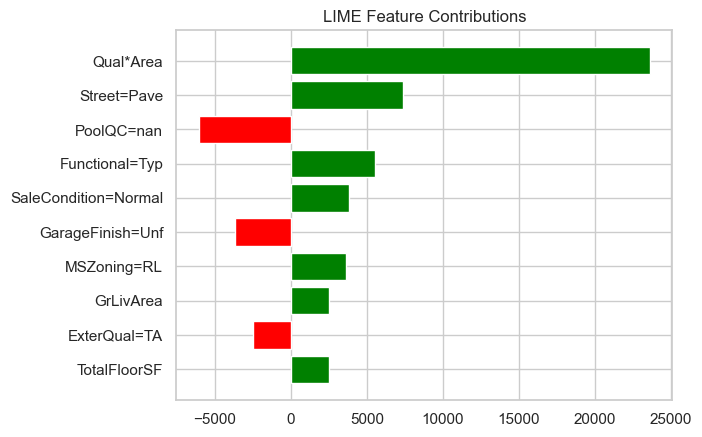

In [101]:
# ============================================================
# FINAL, FULLY-STABLE LIME IMPLEMENTATION (No Errors)
# ============================================================

import numpy as np
import pandas as pd
import lime.lime_tabular
import matplotlib.pyplot as plt

# ============================================================
# 1️⃣ Safe Label Encoder for categorical features
# ============================================================

class SafeLabelEncoder:
    def fit(self, values):
        values = values.astype(str)
        self.classes_ = np.unique(values).tolist()
        if "Unknown" not in self.classes_:
            self.classes_.append("Unknown")
        self.class_to_int = {c: i for i, c in enumerate(self.classes_)}
        return self

    def transform(self, values):
        values = values.astype(str)
        return np.array([self.class_to_int.get(v, self.class_to_int["Unknown"]) for v in values])

    def inverse_transform(self, ints):
        return np.array([self.classes_[i] for i in ints])


# ============================================================
# 2️⃣ Encode categorical columns safely for LIME
# ============================================================

X_train_lime = X_train_raw.copy()
X_test_lime  = X_test_raw.copy()

categorical_cols = X_train_raw.select_dtypes(include=["object"]).columns.tolist()

categorical_idx = []
categorical_names = {}
label_encoders = {}

for col in categorical_cols:
    le = SafeLabelEncoder()
    le.fit(X_train_lime[col])

    X_train_lime[col] = le.transform(X_train_lime[col])
    X_test_lime[col]  = le.transform(X_test_lime[col])

    idx = X_train_lime.columns.get_loc(col)
    categorical_idx.append(idx)
    categorical_names[idx] = le.classes_
    label_encoders[col] = le

print("Categorical encoding for LIME complete.")


# ============================================================
# 3️⃣ Build LIME Explainer (NO DISCRETIZATION → no errors)
# ============================================================

explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_lime.values,
    feature_names=X_train_lime.columns.tolist(),
    categorical_features=categorical_idx,
    categorical_names=categorical_names,
    discretize_continuous=False,   # 🚀 THE KEY FIX
    mode="regression",
    verbose=False
)


# ============================================================
# 4️⃣ Predict function (converts numeric cats back to original strings)
# ============================================================

def predict_fn_lime(x_numeric):
    x_df = pd.DataFrame(x_numeric, columns=X_train_lime.columns)

    # Convert encoded integers → original category strings
    for col in categorical_cols:
        idx = X_train_lime.columns.get_loc(col)
        encoder = label_encoders[col]
        classes = encoder.classes_

        x_df[col] = x_df[col].round().astype(int).clip(0, len(classes) - 1)
        x_df[col] = x_df[col].apply(lambda i: classes[i])

    preds = model.predict(x_df)
    return preds.reshape(-1, 1)


# ============================================================
# 5️⃣ Run LIME on a sample instance
# ============================================================

sample_ind = 10
x_instance = X_test_lime.iloc[sample_ind].values

lime_exp = explainer_lime.explain_instance(
    x_instance,
    predict_fn_lime,
    num_features=10
)


# ============================================================
# 6️⃣ Show LIME results
# ============================================================

lime_table = pd.DataFrame(lime_exp.as_list(), columns=["Feature", "Contribution"])
print("\n🔍 LIME Top Features Table:")
display(lime_table)

lime_exp.as_pyplot_figure()
plt.title("LIME Feature Contributions")
plt.show()